# Galaxy classification

The goal is to determine the demographics of galaxies with spiral arms, which are correlated with star formation in the discs of low-redshift galaxies, and therefore, contribute to the understanding of star formation in the Local Universe. A large citizen science initiative called Galaxy Zoo 2 (1) has collected human annotations of roughly 300000 images of galaxies from the Sloan Digital Sky Survey (2) with the goal of measuring these demographics. The target of inference is the fraction of galaxies with spiral arms. This notebook shows that prediction-powered inference allows for a decrease in the requisite number of human-annotated galaxies by imputing labels via computer vision.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the galaxies data set

Load the data. The data set contains human-annotated labels indicating whether the galaxy has spiral arms (```Y```) and corresponding predicted labels based on computer vision (```Yhat```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "galaxies")
Y_total = data["Y"]
Yhat_total = data["Yhat"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 100

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[n:]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_mean_ci(Yhat_total > 0.5, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0],
                "upper": imputed_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.10it/s]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

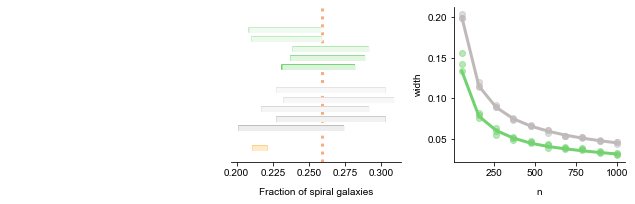

In [5]:
make_plots(
    df,
    "./plots/galaxies.pdf",
    n_idx=3,
    intervals_xlabel="Fraction of spiral galaxies",
    true_theta=true_theta,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \text{fraction of spiral galaxies} \leq 20\%$.

In [6]:
# Find n such that we reject H0: fraction of galaxies < 0.2 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]

alpha_pval = 0.05


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha_pval)
        if ppi_ci[0] > 0.2:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_mean_ci(_Y, alpha=alpha_pval)

        if classical_ci[0] > 0.2:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 1, 1000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 1, 1000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=189 labeled data points to reject the null.
The classical test requires n=449 labeled data points to reject the null.
